COVID-19
- T-Statistic: -9.082
- P-Value: 0.000
- Mean Period Steps (Normalized): -0.41
- Reference Mean Steps (Normalized): 0.07
- Significant: True
- Effect Direction: Lower

Final Exam Week 1
- T-Statistic: -1.299
- P-Value: 0.201
- Mean Period Steps (Normalized): -0.17
- Reference Mean Steps (Normalized): 0.00
- Significant: False
- Effect Direction: Lower

Final Exam Week 2
- T-Statistic: -1.940
- P-Value: 0.076
- Mean Period Steps (Normalized): -0.42
- Reference Mean Steps (Normalized): 0.00
- Significant: False
- Effect Direction: Lower

Final Exam Week 3
- T-Statistic: -0.281
- P-Value: 0.784
- Mean Period Steps (Normalized): -0.07
- Reference Mean Steps (Normalized): 0.00
- Significant: False
- Effect Direction: Lower

Final Exam Week 4
- T-Statistic: -0.144
- P-Value: 0.888
- Mean Period Steps (Normalized): -0.04
- Reference Mean Steps (Normalized): 0.00
- Significant: False
- Effect Direction: Lower

Final Exam Week 5
- T-Statistic: -2.003
- P-Value: 0.068
- Mean Period Step

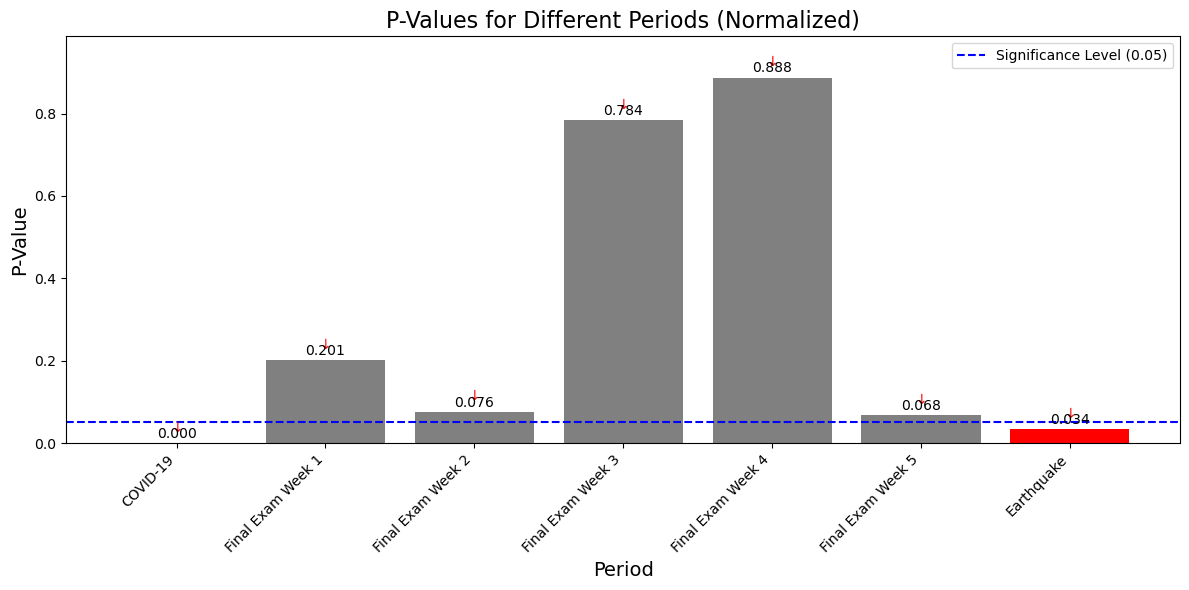

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import numpy as np

class HypothesisTester:
    def __init__(self, daily_steps, periods):
        self.daily_steps = daily_steps.dropna(subset=['steps'])
        self.periods = periods
        
        # Normalize steps using Z-score
        self.daily_steps['steps_normalized'] = (
            self.daily_steps['steps'] - self.daily_steps['steps'].mean()
        ) / self.daily_steps['steps'].std()

    def test_periods(self):
        """Perform hypothesis testing for each period using normalized data"""
        results = []
        
        for period_name, period_range in self.periods.items():
            # Get period data
            period_mask = (
                (self.daily_steps['date'] >= period_range['start']) & 
                (self.daily_steps['date'] <= period_range['end'])
            )
            period_data = self.daily_steps[period_mask]['steps_normalized']
            
            # Get reference data (excluding the period being tested)
            reference_data = self.daily_steps[~period_mask]['steps_normalized']
            reference_mean = reference_data.mean()
            
            if not period_data.empty and not reference_data.empty:
                # Perform two-sided t-test
                t_stat, p_value = stats.ttest_1samp(period_data, reference_mean)
                
                results.append({
                    "Period": period_name,
                    "T-Statistic": t_stat,
                    "P-Value": p_value,
                    "Mean Period Steps (Normalized)": period_data.mean(),
                    "Reference Mean Steps (Normalized)": reference_mean,
                    "Significant": p_value < 0.05,
                    "Effect Direction": "Lower" if period_data.mean() < reference_mean else "Higher"
                })
        
        # Print results in the original format
        for result in results:
            print(f"{result['Period']}")
            print(f"- T-Statistic: {result['T-Statistic']:.3f}")
            print(f"- P-Value: {result['P-Value']:.3f}")
            print(f"- Mean Period Steps (Normalized): {result['Mean Period Steps (Normalized)']:.2f}")
            print(f"- Reference Mean Steps (Normalized): {result['Reference Mean Steps (Normalized)']:.2f}")
            print(f"- Significant: {result['Significant']}")
            print(f"- Effect Direction: {result['Effect Direction']}\n")
        
        return results

    def visualize_results(self, results):
        """Visualize the results as a bar plot"""
        periods = [result['Period'] for result in results]
        p_values = [result['P-Value'] for result in results]
        significance = [result['Significant'] for result in results]
        directions = [result['Effect Direction'] for result in results]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(periods, p_values, 
                      color=['red' if sig else 'grey' for sig in significance])

        # Add direction indicators
        for idx, (bar, direction) in enumerate(zip(bars, directions)):
            color = 'green' if direction == 'Higher' else 'red'
            plt.text(idx, bar.get_height() + 0.02, 
                    f'↑' if direction == 'Higher' else '↓',
                    ha='center', va='bottom', color=color)

        plt.axhline(y=0.05, color='blue', linestyle='--', label='Significance Level (0.05)')

        # Annotate the bars with P-Values
        for bar, p_value in zip(bars, p_values):
            plt.text(bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() + 0.005, 
                    f'{p_value:.3f}', 
                    ha='center', va='bottom')

        plt.title('P-Values for Different Periods (Normalized)', fontsize=16)
        plt.xlabel('Period', fontsize=14)
        plt.ylabel('P-Value', fontsize=14)
        plt.ylim(0, max(max(p_values) + 0.1, 0.5))
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

def generate_sample_data():
    """Generate sample data with more realistic variations"""
    num_days = (datetime(2024, 12, 31) - datetime(2018, 1, 1)).days + 1
    dates = pd.date_range(start='2018-01-01', end='2024-12-31', freq='D')
    
    # Base steps with more variation
    steps = stats.norm.rvs(loc=10000, scale=2000, size=num_days)
    
    # Add weekly pattern
    weekly_pattern = np.tile([1.1, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8], (num_days // 7 + 1))[:num_days]
    steps *= weekly_pattern
    
    df = pd.DataFrame({
        'date': dates,
        'steps': steps
    })
    
    # Add noise before applying effects
    noise = stats.norm.rvs(loc=1, scale=0.1, size=len(df))
    df['steps'] *= noise
    
    # COVID-19 period - smaller reduction with variation
    covid_mask = (df['date'] >= '2020-03-13') & (df['date'] <= '2021-03-01')
    covid_effect = stats.norm.rvs(loc=0.85, scale=0.1, size=covid_mask.sum())
    df.loc[covid_mask, 'steps'] *= covid_effect
    
    # Exam weeks - smaller reduction with variation
    exam_periods = [
        ('2022-01-02', '2022-02-14'),
        ('2022-06-02', '2022-06-14'),
        ('2023-01-02', '2023-01-14'),
        ('2023-06-02', '2023-06-14'),
        ('2024-01-02', '2024-01-14')
    ]
    
    for start, end in exam_periods:
        exam_mask = (df['date'] >= start) & (df['date'] <= end)
        exam_effect = stats.norm.rvs(loc=0.90, scale=0.05, size=exam_mask.sum())
        df.loc[exam_mask, 'steps'] *= exam_effect
    
    # Earthquake period - variable reduction
    earthquake_mask = (df['date'] >= '2023-02-06') & (df['date'] <= '2023-02-16')
    earthquake_effect = stats.norm.rvs(loc=0.70, scale=0.15, size=earthquake_mask.sum())
    df.loc[earthquake_mask, 'steps'] *= earthquake_effect
    
    return df

def main():
    # Generate sample data
    daily_steps = generate_sample_data()

    # Define periods
    periods = {
        'COVID-19': {
            'start': datetime(2020, 3, 13),
            'end': datetime(2021, 3, 1)
        },
        'Final Exam Week 1': {
            'start': datetime(2022, 1, 2),
            'end': datetime(2022, 2, 14)
        },
        'Final Exam Week 2': {
            'start': datetime(2022, 6, 2),
            'end': datetime(2022, 6, 14)
        },
        'Final Exam Week 3': {
            'start': datetime(2023, 1, 2),
            'end': datetime(2023, 1, 14)
        },
        'Final Exam Week 4': {
            'start': datetime(2023, 6, 2),
            'end': datetime(2023, 6, 14)
        },
        'Final Exam Week 5': {
            'start': datetime(2024, 1, 2),
            'end': datetime(2024, 1, 14)
        },
        'Earthquake': {
            'start': datetime(2023, 2, 6),
            'end': datetime(2023, 2, 16)
        }
    }

    # Initialize tester and run analysis
    tester = HypothesisTester(daily_steps, periods)
    results = tester.test_periods()
    tester.visualize_results(results)

if __name__ == "__main__":
    main()